# Simulation of Residual Confounding by SES — Reproducible Research (v2)

This notebook is parameterized for **papermill**, includes **inline unit tests**, and outputs a compact **Results** section and styled figures.

**Parts**
1) **Simulation study** (DAG-informed).  
2) **NHANES scaffold** (skips gracefully without XPTs).

Artifacts are written to `artifacts/`.


## Parameters


In [17]:

# These parameters can be overridden by papermill
N_POP = 120_000
SEED = 1234
ART_DIR = "artifacts"
NHANES_BASE_DIR = ""   # e.g., "/path/to/nhanes_xpt"
NHANES_CYCLES   = ["C","D","E","F","G","H","I","J"]

R2_DENOM = 'fixed_pop'   # 'fixed_pop' or 'cond_specific'
R2_GRID_DESC = 'equal_2_98pct_40pts'
NHANES_AUTO_DOWNLOAD = True
NHANES_DATASETS = ['DEMO','BPX','BMX','MCQ','SMQ']


In [18]:

import os, sys, json, platform, numpy as np, pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

os.makedirs(ART_DIR, exist_ok=True)
print("Artifacts dir:", os.path.abspath(ART_DIR))
print("Timestamp:", datetime.utcnow().isoformat()+"Z")


Artifacts dir: f:\OneDrive\Desktop\ses_residual_confounding\artifacts
Timestamp: 2025-08-14T16:15:20.288565Z


C:\Users\rossd\AppData\Local\Temp\ipykernel_20640\4269414092.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("Timestamp:", datetime.utcnow().isoformat()+"Z")


## Part A — Simulation code


In [19]:

"""
SES Simulation Scaffold (Python)
================================

A comprehensive simulation framework for studying socioeconomic status (SES) effects on health
outcomes through complex, non-linear causal pathways with selection bias and measurement error.

Overview
--------
This module implements a sophisticated data generating mechanism that simulates realistic
relationships between socioeconomic status and disease outcomes, incorporating:

1. **Non-linear SES effects**: Complex relationships between true SES and health mediators
2. **Selection bias**: Biobank-like participation patterns that create systematic sampling bias
3. **Measurement error**: Noisy observation of true SES, mimicking real-world data limitations
4. **Multiple analytical approaches**: Comparison of traditional vs. modern causal inference methods

Key Features
------------
- **Realistic Data Generation**: Simulates population-level data with complex causal relationships
- **Selection Mechanisms**: Models biobank participation bias based on health and socioeconomic factors
- **Multiple SES Representations**: True latent SES*, observed noisy SES, and categorical quintiles
- **Flexible Modeling**: Supports linear models, splines, and g-computation for causal inference
- **Performance Metrics**: Multiple R² variants and Shapley value decomposition for model comparison

Analytical Approaches Compared
------------------------------
A) **Traditional Mis-specified Models**:
   - Linear SES effects using categorical quintiles
   - Over-adjusted models including mediators (collider bias)

B) **Flexible Spline Models**:
   - Non-parametric modeling of SES-outcome relationships
   - Comparison between oracle (SES*) and proxy (SES_obs) versions

C) **G-computation Dose-Response**:
   - Causal intervention curves: E[Y | do(SES = a)]
   - Oracle estimates using true SES* vs. proxy estimates using observed SES

Mathematical Framework
----------------------
The data generating process follows this causal structure:
    C (confounders) → SES* → M (mediators) → Y (outcome)
                  ↓                        ↓
               SES_obs                      S (selection)

Where:
- C: Baseline confounders (age, sex, genetic PCs)
- SES*: True latent socioeconomic status
- SES_obs: Observed SES proxy with measurement error
- M: Health-related mediators (BMI, smoking, blood pressure)
- Y: Binary disease outcome
- S: Biobank participation (selection indicator)

Usage Example
-------------
>>> # Basic simulation run
>>> results, pop, biobank, *curves = run_demo(n_pop=50000, seed=123)
>>> print(f"Population size: {results['n_population']}")
>>> print(f"Biobank sample: {results['n_biobank']}")
>>> print(f"True causal R²: {results['causal_R2_true']:.3f}")

>>> # Custom parameters
>>> params = DGMParams(n=100000, seed=456, ses_me_sd=0.5)
>>> pop_data = simulate_population(params)
>>> biobank_data = sample_biobank(pop_data)

Dependencies
------------
- numpy: Numerical computations and random number generation
- pandas: Data manipulation and analysis
- statsmodels: Statistical modeling and GLM fitting
- patsy: Formula interface for statistical models (splines)

Author
------
Dr. Ross A. Dunne

Notes
-----
This simulation is designed for methodological research comparing different approaches
to estimating socioeconomic effects on health outcomes in the presence of selection bias
and measurement error. The default parameters are calibrated to produce realistic effect
sizes and prevalence rates typical of epidemiological studies.
"""

from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional, Union, Any
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrix

# -----------------
# Helper functions
# -----------------

def logistic(x: np.ndarray) -> np.ndarray:
    """
    Compute the logistic (sigmoid) function.

    Transforms real-valued inputs to probabilities in (0, 1) using the logistic function:
    σ(x) = 1 / (1 + exp(-x))

    Parameters
    ----------
    x : array-like
        Input values to transform. Can be scalar, vector, or array.

    Returns
    -------
    np.ndarray
        Logistic transformation of input, bounded in (0, 1).

    Examples
    --------
    >>> logistic(0)
    0.5
    >>> logistic(np.array([-2, 0, 2]))
    array([0.119, 0.5, 0.881])
    """
    return 1.0 / (1.0 + np.exp(-x))

def standardize(x: np.ndarray) -> np.ndarray:
    """
    Standardize a variable to have mean 0 and standard deviation 1.

    Applies z-score normalization: z = (x - μ) / σ

    Parameters
    ----------
    x : array-like
        Input variable to standardize.

    Returns
    -------
    np.ndarray
        Standardized variable with mean ≈ 0 and std ≈ 1.

    Examples
    --------
    >>> x = np.array([1, 2, 3, 4, 5])
    >>> z = standardize(x)
    >>> np.mean(z), np.std(z)
    (0.0, 1.0)
    """
    return (x - np.mean(x)) / np.std(x)

def mc_fadden_r2(model_llf: float, null_llf: float) -> float:
    """
    Calculate McFadden's pseudo-R² for logistic regression models.

    McFadden's R² is a measure of goodness-of-fit for maximum likelihood models,
    analogous to R² in linear regression. It compares the log-likelihood of the
    fitted model to that of a null (intercept-only) model.

    Formula: R²_McF = 1 - (LL_model / LL_null)

    Parameters
    ----------
    model_llf : float
        Log-likelihood of the fitted model.
    null_llf : float
        Log-likelihood of the null (intercept-only) model.

    Returns
    -------
    float
        McFadden's pseudo-R², typically between 0 and 1.
        Values of 0.2-0.4 are considered excellent fit.

    Notes
    -----
    Unlike linear R², McFadden's R² does not represent proportion of variance
    explained. It measures relative improvement in log-likelihood over the null model.
    """
    return 1 - (model_llf / null_llf)

def tjur_r2(y_true: np.ndarray, p_hat: np.ndarray) -> float:
    """
    Calculate Tjur's coefficient of discrimination (R²_D) for binary outcomes.

    Tjur's R² measures the difference in mean predicted probabilities between
    cases (y=1) and controls (y=0). It provides an intuitive measure of how well
    the model discriminates between the two groups.

    Formula: R²_D = E[p̂|Y=1] - E[p̂|Y=0]

    Parameters
    ----------
    y_true : array-like
        True binary outcomes (0 or 1).
    p_hat : array-like
        Predicted probabilities from the model.

    Returns
    -------
    float
        Tjur's R², ranging from 0 (no discrimination) to 1 (perfect discrimination).

    Notes
    -----
    Tjur's R² is bounded between 0 and 1 and has a direct interpretation:
    it represents the difference in average predicted probability between
    positive and negative cases.

    References
    ----------
    Tjur, T. (2009). Coefficients of determination in logistic regression models.
    The American Statistician, 63(4), 366-372.
    """
    y_true = np.asarray(y_true)
    p_hat = np.asarray(p_hat)
    return float(np.mean(p_hat[y_true==1]) - np.mean(p_hat[y_true==0]))

def partial_r2_mcfadden(llf_full: float, llf_reduced: float, null_llf: float) -> float:
    """
    Calculate partial (incremental) McFadden's R² for nested model comparison.

    Measures the additional explanatory power gained by adding variables to a model,
    expressed as the difference in McFadden's R² between the full and reduced models.

    Formula: ΔR²_McF = R²_McF(full) - R²_McF(reduced)

    Parameters
    ----------
    llf_full : float
        Log-likelihood of the full model (with additional variables).
    llf_reduced : float
        Log-likelihood of the reduced model (baseline).
    null_llf : float
        Log-likelihood of the null (intercept-only) model.

    Returns
    -------
    float
        Incremental McFadden's R² contributed by the additional variables.
        Positive values indicate improvement in model fit.

    Notes
    -----
    This measure is useful for assessing the contribution of specific variable groups
    in nested model comparisons, similar to partial R² in linear regression.
    """
    return mc_fadden_r2(llf_full, null_llf) - mc_fadden_r2(llf_reduced, null_llf)

def shapley_two_groups_r2(llf_null: float, llf_g1: float, llf_g2: float, llf_both: float) -> Dict[str, float]:
    """
    Compute Shapley value decomposition of McFadden's R² for two covariate groups.

    Applies game-theoretic Shapley values to fairly attribute the total model R²
    between two groups of covariates, accounting for their interactions and
    order-dependence in contribution calculations.

    The Shapley value represents each group's average marginal contribution across
    all possible orders of adding groups to the model, providing a fair allocation
    of the total explanatory power.

    Parameters
    ----------
    llf_null : float
        Log-likelihood of the null (intercept-only) model.
    llf_g1 : float
        Log-likelihood of model with group 1 covariates only.
    llf_g2 : float  
        Log-likelihood of model with group 2 covariates only.
    llf_both : float
        Log-likelihood of full model with both groups.

    Returns
    -------
    Dict[str, float]
        Dictionary containing:
        - 'G1_share': Shapley value for group 1 (average marginal contribution)
        - 'G2_share': Shapley value for group 2 (average marginal contribution)  
        - 'R2_total': Total McFadden's R² of the full model

    Notes
    -----
    For two groups, the Shapley value is the average of marginal contributions
    when added first vs. second:

    \u03c6₁ = 0.5 × [(R²₁ - R²₀) + (R²₁₂ - R²₂)]
    \u03c6₂ = 0.5 × [(R²₂ - R²₀) + (R²₁₂ - R²₁)]

    Where R²ᵢ denotes McFadden's R² for the model with group i.

    Examples
    --------
    >>> # Example with SES and demographic covariates
    >>> shap_results = shapley_two_groups_r2(
    ...     llf_null=-1000, llf_g1=-950, llf_g2=-980, llf_both=-920
    ... )
    >>> print(f"SES contribution: {shap_results['G1_share']:.3f}")
    >>> print(f"Demographics contribution: {shap_results['G2_share']:.3f}")
    """
    r2_null = 0.0
    r2_g1 = 1 - (llf_g1 / llf_null)
    r2_g2 = 1 - (llf_g2 / llf_null)
    r2_both = 1 - (llf_both / llf_null)

    # marginal contributions when added first vs second
    contrib_g1_first = r2_g1 - r2_null
    contrib_g1_second = r2_both - r2_g2
    contrib_g2_first = r2_g2 - r2_null
    contrib_g2_second = r2_both - r2_g1

    return {
        "G1_share": float(0.5 * (contrib_g1_first + contrib_g1_second)),
        "G2_share": float(0.5 * (contrib_g2_first + contrib_g2_second)),
        "R2_total": float(r2_both),
    }

# -----------------
# Data Generating Mechanism
# -----------------

@dataclass
class DGMParams:
    """
    Parameters for the Data Generating Mechanism (DGM) in SES simulation.

    This class encapsulates all tunable parameters that control the simulation of
    population data, including sample size, selection bias mechanisms, measurement
    error specifications, and outcome prevalence calibration.

    Attributes
    ----------
    n : int, default=200_000
        Total population size for simulation. Larger values provide more stable
        estimates but increase computational time. Recommended: 50K-500K.

    seed : int, default=42
        Random seed for reproducible results across simulation runs.

    Selection Bias Parameters
    -------------------------
    These parameters control biobank participation probability via logistic model:
    logit(P(S=1)) = sel_intercept + sel_ses*SES* + sel_smoke*smoke + ...

    sel_intercept : float, default=-2.2
        Intercept term controlling overall participation rate. More negative values
        lead to lower participation rates. Default yields ~5-15% participation.

    sel_ses : float, default=0.6
        Effect of true SES on participation. Positive values mean higher SES
        individuals are more likely to participate (typical in biobanks).

    sel_smoke : float, default=-0.8
        Effect of smoking on participation. Negative values reflect that smokers
        are less likely to participate in health studies.

    sel_bmi : float, default=-0.08
        Effect of BMI (per unit above 25) on participation. Negative values
        indicate that higher BMI reduces participation likelihood.

    sel_age : float, default=0.10
        Effect of standardized age on participation. Positive values reflect
        that older individuals may be more likely to participate.

    sel_risk_score : float, default=-0.7
        Effect of overall health risk score on participation. Negative values
        implement "healthy volunteer bias" - healthier individuals more likely
        to participate.

    Measurement Error Parameters
    ----------------------------
    ses_me_sd : float, default=0.7
        Standard deviation of measurement error in observed SES proxy.
        Higher values create more attenuation bias. Typical range: 0.3-1.0.
        Formula: SES_obs = 0.8*SES* + N(0, ses_me_sd²)

    Outcome Parameters
    ------------------
    y_intercept : float, default=-4.1
        Intercept term in outcome logistic model controlling baseline disease
        prevalence. Adjust to achieve desired population prevalence (target: 10-20%).
        More negative values reduce prevalence.

    Notes
    -----
    Default parameters are calibrated to produce realistic epidemiological patterns:
    - Participation rates similar to large biobanks (5-15%)
    - Healthy volunteer bias and socioeconomic selection
    - Moderate measurement error in SES proxy
    - Disease prevalence typical of chronic conditions

    Examples
    --------
    >>> # Default parameters
    >>> params = DGMParams()
    >>> 
    >>> # High measurement error scenario
    >>> params_noisy = DGMParams(ses_me_sd=1.2, n=100_000)
    >>> 
    >>> # Reduced selection bias
    >>> params_less_bias = DGMParams(sel_ses=0.2, sel_risk_score=-0.3)
    """
    n: int = 200_000
    seed: int = 42

    # Selection strength parameters
    sel_intercept: float = -2.2   # controls sampling fraction (~5-15% typical for demo)
    sel_ses: float = 0.6
    sel_smoke: float = -0.8
    sel_bmi: float = -0.08  # per unit BMI above 25
    sel_age: float = 0.10
    sel_risk_score: float = -0.7  # healthier more likely to volunteer

    # Measurement error for observed SES proxy
    ses_me_sd: float = 0.7

    # Outcome base rate calibrator
    y_intercept: float = -4.1  # tweak to get ~10-20% prevalence in population

def simulate_population(params: DGMParams) -> pd.DataFrame:
    """
    Generate synthetic population data with complex SES-health relationships.

    Creates a realistic population dataset incorporating non-linear relationships
    between socioeconomic status and health outcomes, with multiple mediating
    pathways and selection mechanisms that mirror real-world biobank studies.

    The data generating process follows this causal structure:
    C (age, sex, PC1) → SES* → M (BMI, smoking, SBP) → Y (disease)
                     ↓                              ↓
                  SES_obs                            S (selection)

    Parameters
    ----------
    params : DGMParams
        Configuration object containing all simulation parameters including
        sample size, selection mechanisms, and measurement error specifications.

    Returns
    -------
    pd.DataFrame
        Simulated population data with columns:
        - age: Age in years (40-85, mean≈60)
        - sex: Binary sex indicator (0=female, 1=male)
        - pc1: First principal component (genetic/ancestry proxy)
        - ses_star: True latent SES (standardized)
        - ses_obs: Observed SES proxy with measurement error
        - ses_quintile: Categorical SES (0-4 quintiles)
        - bmi: Body mass index with quadratic SES relationship
        - sbp: Systolic blood pressure with saturating SES effect
        - smoke: Binary smoking indicator with threshold effect
        - y: Binary disease outcome
        - s: Binary selection/participation indicator
        - p_s: Participation probability
        - p_y: Disease probability

    Notes
    -----
    Key relationships implemented:

    1. **SES Generation**: SES* ~ N(0.15*(50-age) + 0.15*sex + 0.25*PC1, 1)
    2. **Measurement Error**: SES_obs = 0.8*SES* + N(0, σ²)
    3. **BMI (U-shaped)**: BMI ~ 27.5 + 1.2*(SES*-0.2)² + noise
    4. **Smoking (threshold)**: Higher rates below SES* = -0.5
    5. **Blood Pressure (saturating)**: Improvement plateaus at high SES
    6. **Disease**: Direct SES effect plus mediation through risk factors
    7. **Selection**: Healthy volunteer bias with SES-dependent participation

    The simulation produces realistic epidemiological patterns including:
    - Non-linear dose-response relationships
    - Measurement error attenuation
    - Selection bias favoring healthier, higher-SES participants

    Examples
    --------
    >>> params = DGMParams(n=50000, seed=123)
    >>> pop_data = simulate_population(params)
    >>> print(f"Population size: {len(pop_data)}")
    >>> print(f"Disease prevalence: {pop_data['y'].mean():.1%}")
    >>> print(f"Participation rate: {pop_data['s'].mean():.1%}")
    """
    rng = np.random.default_rng(params.seed)
    n = params.n

    # Baseline covariates C
    age = rng.normal(60, 10, n).clip(40, 85)
    sex = rng.integers(0, 2, n)  # 0=female, 1=male
    pc1 = rng.normal(0, 1, n)

    # Latent SES*
    ses_star = rng.normal(loc=0.15 * standardize(50 - age) + 0.15*sex + 0.25*pc1, scale=1.0, size=n)

    # Observed SES proxy (noisy, then optionally coarsened)
    ses_obs = 0.8 * ses_star + rng.normal(0, params.ses_me_sd, n)

    # Simple quintiles (coarsened)
    q = pd.qcut(ses_obs, 5, labels=False)  # 0..4
    ses_quintile = q.astype(int)

    # Mediators (non-linear)
    # BMI: quadratic (U-ish), lower with mid SES*
    bmi = 27.5 + 1.2*(ses_star - 0.2)**2 + 0.05*(age-60) + 0.6*sex + rng.normal(0, 2.5, n)

    # Smoking: logistic with threshold and SES*
    lp_smoke = -0.5 - 1.2*ses_star + 0.6*(ses_star < -0.5).astype(float) + 0.01*(age-60) + 0.2*sex
    p_smoke = logistic(lp_smoke)
    smoke = rng.binomial(1, p_smoke, n)

    # SBP: saturating improvement with SES*
    sbp = 125 - 4*np.log1p(np.exp(ses_star - 0.0)) + 0.12*(age-60) + 3.0*sex + rng.normal(0, 8.0, n)

    # Outcome Y (binary disease within timeframe)
    # Direct SES* (mild monotone + threshold), plus mediators, plus C
    g_ses = 0.25*ses_star + 0.15*(ses_star < -0.8).astype(float)
    lp_y = (params.y_intercept + g_ses
            + 0.06*(sbp-120) + 0.08*(bmi-25) + 1.0*smoke
            + 0.018*(age-60) + 0.12*sex)

    p_y = logistic(lp_y)
    y = rng.binomial(1, p_y, n)

    # Selection S (biobank participation)
    # Use an approximate risk score (without intercept) as a driver of selection
    risk_score = (g_ses + 0.06*(sbp-120) + 0.08*(bmi-25) + 1.0*smoke + 0.018*(age-60) + 0.12*sex)
    lp_s = (params.sel_intercept + params.sel_ses*ses_star
            + params.sel_smoke*smoke
            + params.sel_bmi*(bmi-25)
            + params.sel_age*standardize(age)
            + params.sel_risk_score*risk_score)
    p_s = logistic(lp_s)
    s = rng.binomial(1, p_s, n)

    df = pd.DataFrame({
        "age": age,
        "sex": sex,
        "pc1": pc1,
        "ses_star": ses_star,
        "ses_obs": ses_obs,
        "ses_quintile": ses_quintile,
        "bmi": bmi,
        "sbp": sbp,
        "smoke": smoke,
        "y": y,
        "s": s,
        "p_s": p_s,
        "p_y": p_y
    })
    return df

def sample_biobank(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract the biobank sample from population data based on selection indicator.

    Filters the population dataset to include only individuals who would
    participate in a biobank study (s=1), creating a selected sample that
    exhibits systematic bias relative to the target population.

    Parameters
    ----------
    df : pd.DataFrame
        Population dataset containing selection indicator 's'.

    Returns
    -------
    pd.DataFrame
        Biobank sample containing only participants (s=1).
        Typically 5-15% of the original population size.

    Notes
    -----
    The biobank sample will exhibit:
    - Higher mean SES (selection bias)
    - Lower disease prevalence (healthy volunteer bias)
    - Different covariate distributions
    - Potential collider bias when conditioning on selection

    This function simulates the real-world scenario where biobank participants
    are not representative of the general population, creating challenges for
    causal inference and generalizability.

    Examples
    --------
    >>> pop_data = simulate_population(DGMParams(n=100000))
    >>> biobank_data = sample_biobank(pop_data)
    >>> print(f"Selection ratio: {len(biobank_data)/len(pop_data):.1%}")
    >>> print(f"SES bias: {biobank_data['ses_star'].mean():.2f} vs {pop_data['ses_star'].mean():.2f}")
    """
    return df.loc[df["s"]==1].copy()

# -----------------
# Analytic models
# -----------------

def fit_logit(formula: str, data: pd.DataFrame, weights: Optional[np.ndarray] = None) -> Any:
    """
    Fit a logistic regression model using statsmodels formula interface.

    Convenience wrapper for fitting binary logistic regression models with
    optional frequency weights, commonly used in epidemiological analyses.

    Parameters
    ----------
    formula : str
        Model formula in patsy/R syntax (e.g., 'y ~ x1 + x2 + bs(x3, df=5)').
        Supports transformations, interactions, and spline terms.
    data : pd.DataFrame
        Dataset containing variables referenced in the formula.
    weights : array-like, optional
        Frequency weights for weighted logistic regression. Default is None.

    Returns
    -------
    fitted model object
        Fitted logistic regression results object with methods for prediction,
        summary statistics, and model diagnostics.

    Examples
    --------
    >>> # Simple logistic regression
    >>> results = fit_logit('y ~ x1 + x2', data)
    >>> 
    >>> # With spline terms
    >>> results = fit_logit('y ~ bs(ses, df=5) + age + sex', data)
    >>> 
    >>> # With weights
    >>> results = fit_logit('y ~ x1 + x2', data, weights=sample_weights)
    """
    model = sm.GLM.from_formula(formula=formula, data=data, family=sm.families.Binomial(), freq_weights=weights)
    res = model.fit()
    return res

def null_llf(y: np.ndarray) -> float:
    """
    Calculate log-likelihood of the null (intercept-only) model for binary outcomes.

    Computes the maximum likelihood under the null hypothesis that all observations
    have the same probability of success, estimated as the sample proportion.
    This serves as a baseline for calculating pseudo-R² measures.

    Parameters
    ----------
    y : array-like
        Binary outcome variable (0s and 1s).

    Returns
    -------
    float
        Log-likelihood of the null model: LL₀ = Σᵢ [yᵢlog(p̂) + (1-yᵢ)log(1-p̂)]
        where p̂ is the sample proportion of successes.

    Notes
    -----
    The null model probability is clipped to [1e-6, 1-1e-6] to avoid numerical
    issues with log(0) when all outcomes are 0 or 1.

    This function is essential for computing McFadden's pseudo-R² and related
    goodness-of-fit measures for logistic regression models.

    Examples
    --------
    >>> y = np.array([0, 1, 0, 1, 1])
    >>> ll_null = null_llf(y)
    >>> print(f"Null log-likelihood: {ll_null:.3f}")
    """
    p = np.clip(np.mean(y), 1e-6, 1-1e-6)
    ll = np.sum(y*np.log(p) + (1-y)*np.log(1-p))
    return float(ll)

def g_compute_dose_response(model: Any, data: pd.DataFrame, ses_var: str, a_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Estimate m(a) = E[Y | do(SES= a)] by setting SES variable to a and predicting with the fitted model,
    averaging over the empirical distribution of observed confounders in `data`.
    Note: This treats `ses_var` as the manipulable exposure in the fitted model (could be SES* oracle or SES_obs proxy).
    """
    base = data.copy()
    means = []
    for a in a_grid:
        tmp = base.copy()
        tmp[ses_var] = a
        # For splines, the design matrix updates automatically via formula interface.
        p = model.predict(tmp)
        means.append(np.mean(p))
    return a_grid, np.array(means)

def true_dose_response(df_population: pd.DataFrame, a_grid: np.ndarray, seed: int=7) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the true m(a) = E[Y | do(SES*=a)] by re-simulating mediators and outcome
    while fixing SES* := a and integrating over exogenous noise and baseline covariates.
    """
    rng = np.random.default_rng(seed)
    age = df_population["age"].to_numpy()
    sex = df_population["sex"].to_numpy()
    pc1 = df_population["pc1"].to_numpy()

    means = []
    n = len(df_population)
    for a in a_grid:
        # mediators under intervention
        bmi = 27.5 + 1.2*(a - 0.2)**2 + 0.05*(age-60) + 0.6*sex + rng.normal(0, 2.5, n)
        lp_smoke = -0.5 - 1.2*a + 0.6*(a < -0.5) + 0.01*(age-60) + 0.2*sex
        p_smoke = 1.0 / (1.0 + np.exp(-lp_smoke))
        smoke = rng.binomial(1, p_smoke, n)
        sbp = 125 - 4*np.log1p(np.exp(a - 0.0)) + 0.12*(age-60) + 3.0*sex + rng.normal(0, 8.0, n)
        g_ses = 0.25*a + 0.15*(a < -0.8)
        lp_y = (-4.1 + g_ses
                + 0.06*(sbp-120) + 0.08*(bmi-25) + 1.0*smoke
                + 0.018*(age-60) + 0.12*sex)
        p_y = 1.0 / (1.0 + np.exp(-lp_y))
        means.append(np.mean(p_y))
    return a_grid, np.array(means)

def causal_R2_from_curve(m_a: np.ndarray, y: np.ndarray) -> float:
    """
    Causal R^2 (risk scale): Var_a( m(a) ) / Var(Y), where a ~ empirical SES distribution.
    Here we approximate Var_a(m(a)) by taking the variance across m(a) evaluated over
    SES grid weighted equally; you can reweight by SES density if desired.
    """
    var_y = np.var(y, ddof=0)
    var_ma = np.var(m_a, ddof=0)
    return float(var_ma / var_y)

# -----------------
# Demo / single-run analysis
# -----------------

def run_demo(n_pop: int = 200_000, seed: int = 42) -> Tuple[Dict[str, float], pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, Any, Any, Any, Any]:
    """
    Execute complete simulation study comparing SES-health causal inference methods.

    Runs a comprehensive analysis comparing traditional epidemiological approaches
    with modern causal inference methods for estimating socioeconomic effects on
    health outcomes in the presence of selection bias and measurement error.

    This function implements the full simulation pipeline:
    1. Generate population with complex SES-health relationships
    2. Apply biobank selection bias
    3. Fit multiple analytical models
    4. Estimate causal dose-response curves
    5. Compute performance metrics and decompositions

    Parameters
    ----------
    n_pop : int, default=200_000
        Population size for simulation. Larger values provide more stable
        estimates but increase computational time.
    seed : int, default=42
        Random seed for reproducible results.

    Returns
    -------
    Tuple containing:
        results : Dict[str, float]
            Performance metrics including:
            - Sample sizes and prevalence rates
            - McFadden and Tjur R² for different models
            - Causal R² estimates (true, oracle, proxy)
            - Shapley value decomposition

        pop : pd.DataFrame
            Full population dataset

        biobank : pd.DataFrame  
            Selected biobank sample

        a_grid : np.ndarray
            SES* intervention grid

        a_grid_obs : np.ndarray
            SES_obs intervention grid

        m_true : np.ndarray
            True causal dose-response curve

        m_hat_star : np.ndarray
            Oracle G-computation estimates (using SES*)

        m_hat_obs : np.ndarray
            Proxy G-computation estimates (using SES_obs)

        res_lin, res_over, res_spline_obs, res_spline_star : fitted model objects
            Fitted regression models for further analysis

    Notes
    -----
    The analysis compares:

    **Traditional Approaches (Problematic):**
    - Linear quintile models (mis-specification)
    - Over-adjusted models including mediators (collider bias)

    **Modern Approaches (Preferred):**
    - Flexible spline models capturing non-linearity
    - G-computation for causal dose-response curves
    - Oracle vs. proxy SES comparisons

    **Key Metrics:**
    - McFadden's/Tjur's R²: Traditional model fit
    - Causal R²: Proportion of variance from SES interventions
    - Shapley values: Fair attribution of explanatory power

    The simulation demonstrates:
    - Bias from selection and measurement error
    - Advantages of flexible modeling approaches
    - Importance of causal vs. predictive frameworks

    Examples
    --------
    >>> # Run basic demo
    >>> results, pop, biobank, *curves = run_demo(n_pop=50000)
    >>> print(f"True causal R²: {results['causal_R2_true']:.3f}")
    >>> print(f"Biobank bias: {results['mean_y_population']:.3f} vs {results['mean_y_biobank']:.3f}")
    >>> 
    >>> # Custom parameters
    >>> results, *_ = run_demo(n_pop=100000, seed=456)
    >>> 
    >>> # Extract dose-response curves for plotting
    >>> _, _, _, a_grid, a_grid_obs, m_true, m_oracle, m_proxy, *_ = run_demo()
    >>> plt.plot(a_grid, m_true, label='True curve')
    >>> plt.plot(a_grid, m_oracle, label='Oracle estimate')
    >>> plt.plot(a_grid_obs, m_proxy, label='Proxy estimate')
    """
    params = DGMParams(n=n_pop, seed=seed)
    pop = simulate_population(params)
    biobank = pop.loc[pop["s"]==1].copy()

    # SES grids
    a_grid = np.linspace(np.percentile(pop["ses_star"], 2),
                         np.percentile(pop["ses_star"], 98), 30)
    a_grid_obs = np.linspace(np.percentile(pop["ses_obs"], 2),
                             np.percentile(pop["ses_obs"], 98), 30)

    # True curve (population, oracle)
    _, m_true = true_dose_response(pop, a_grid)

    # A) Mis-specified models (selected sample)
    # Linear SES quintile (treated numeric) + C
    formula_lin = "y ~ ses_quintile + age + sex + pc1"
    res_lin = sm.GLM.from_formula(formula_lin, data=biobank, family=sm.families.Binomial()).fit()
    p_lin = res_lin.predict(biobank)
    r2_lin_mcf = mc_fadden_r2(res_lin.llf, null_llf(biobank["y"].to_numpy()))
    r2_lin_tjur = tjur_r2(biobank["y"], p_lin)

    # Over-adjustment (include mediators; typical risk-factor model)
    formula_over = "y ~ ses_quintile + age + sex + pc1 + bmi + sbp + smoke"
    res_over = sm.GLM.from_formula(formula_over, data=biobank, family=sm.families.Binomial()).fit()
    p_over = res_over.predict(biobank)
    r2_over_mcf = mc_fadden_r2(res_over.llf, null_llf(biobank["y"].to_numpy()))

    # B) Flexible spline on observed SES
    biobank = biobank.assign(
        ses_obs_spline = biobank["ses_obs"]  # keep name for formula
    )
    formula_spline_obs = "y ~ bs(ses_obs_spline, df=5) + age + sex + pc1"
    res_spline_obs = sm.GLM.from_formula(formula_spline_obs, data=biobank, family=sm.families.Binomial()).fit()

    # (Oracle) Flexible spline on SES*
    biobank = biobank.assign(
        ses_star_spline = biobank["ses_star"]
    )
    formula_spline_star = "y ~ bs(ses_star_spline, df=5) + age + sex + pc1"
    res_spline_star = sm.GLM.from_formula(formula_spline_star, data=biobank, family=sm.families.Binomial()).fit()

    # C) G-computation curves (selected sample)
    _, m_hat_obs = g_compute_dose_response(res_spline_obs, biobank, "ses_obs_spline", a_grid_obs)
    _, m_hat_star = g_compute_dose_response(res_spline_star, biobank, "ses_star_spline", a_grid)

    # Causal R^2 (approx) using curves; compare to observed Var(Y)
    r2_causal_true = causal_R2_from_curve(m_true, pop["y"].to_numpy())
    r2_causal_oracle = causal_R2_from_curve(m_hat_star, biobank["y"].to_numpy())
    r2_causal_proxy = causal_R2_from_curve(m_hat_obs, biobank["y"].to_numpy())

    # Simple two-group Shapley (SES vs others) on selected sample
    # Group 1: SES* spline (oracle); Group 2: C = age, sex, pc1
    llf_null = null_llf(biobank["y"].to_numpy())
    llf_g1 = sm.GLM.from_formula("y ~ bs(ses_star_spline, df=5)", data=biobank, family=sm.families.Binomial()).fit().llf
    llf_g2 = sm.GLM.from_formula("y ~ age + sex + pc1", data=biobank, family=sm.families.Binomial()).fit().llf
    llf_both = res_spline_star.llf
    shap = shapley_two_groups_r2(llf_null, llf_g1, llf_g2, llf_both)

    out = {
        "n_population": int(len(pop)),
        "n_biobank": int(len(biobank)),
        "mean_y_population": float(pop["y"].mean()),
        "mean_y_biobank": float(biobank["y"].mean()),
        "mcFadden_R2_linear_quintile": float(r2_lin_mcf),
        "Tjur_R2_linear_quintile": float(r2_lin_tjur),
        "mcFadden_R2_overadjusted": float(r2_over_mcf),
        "causal_R2_true": float(r2_causal_true),
        "causal_R2_oracle_SESstar": float(r2_causal_oracle),
        "causal_R2_proxy_SESobs": float(r2_causal_proxy),
        "Shapley_SESstar_share": shap["G1_share"],
        "Shapley_C_share": shap["G2_share"],
        "Shapley_R2_total": shap["R2_total"],
    }
    return out, pop, biobank, a_grid, a_grid_obs, m_true, m_hat_star, m_hat_obs, res_lin, res_over, res_spline_obs, res_spline_star


# -----------------
# Main execution
# -----------------

if __name__ == "__main__":
    """
    Run the SES simulation demo when script is executed directly.
    """
    print("SES Simulation Scaffold - Running Demo Analysis")
    print("=" * 50)

    # Run the simulation
    print("Generating population and running analysis...")
    results, pop, biobank, a_grid, a_grid_obs, m_true, m_hat_star, m_hat_obs, *models = run_demo(
        n_pop=50_000,  # Smaller sample for faster demo
        seed=42
    )

    print("\n" + "Results Summary" + "\n" + "-" * 20)

    # Sample sizes and basic stats
    print(f"Population size: {results['n_population']:,}")
    print(f"Biobank sample: {results['n_biobank']:,} ({results['n_biobank']/results['n_population']:.1%})")
    print(f"Population disease prevalence: {results['mean_y_population']:.1%}")
    print(f"Biobank disease prevalence: {results['mean_y_biobank']:.1%}")

    # Model performance comparison
    print(f"\nModel Performance (McFadden R²):")
    print(f"  Linear quintile model: {results['mcFadden_R2_linear_quintile']:.3f}")
    print(f"  Over-adjusted model: {results['mcFadden_R2_overadjusted']:.3f}")
    print(f"  Tjur R² (linear model): {results['Tjur_R2_linear_quintile']:.3f}")

    # Causal R² estimates
    print(f"\nCausal R² Estimates:")
    print(f"  True causal R²: {results['causal_R2_true']:.3f}")
    print(f"  Oracle estimate (SES*): {results['causal_R2_oracle_SESstar']:.3f}")
    print(f"  Proxy estimate (SES_obs): {results['causal_R2_proxy_SESobs']:.3f}")

    # Shapley decomposition
    print(f"\nShapley Value Decomposition:")
    print(f"  SES* contribution: {results['Shapley_SESstar_share']:.3f}")
    print(f"  Other covariates: {results['Shapley_C_share']:.3f}")
    print(f"  Total R²: {results['Shapley_R2_total']:.3f}")

    # Interpretation
    print(f"\n" + "Key Insights" + "\n" + "-" * 15)

    # Selection bias
    bias_direction = "healthier" if results['mean_y_biobank'] < results['mean_y_population'] else "sicker"
    bias_magnitude = abs(results['mean_y_biobank'] - results['mean_y_population']) / results['mean_y_population']
    print(f"• Biobank shows {bias_magnitude:.1%} {bias_direction} population (healthy volunteer bias)")

    # Causal vs predictive
    oracle_vs_true = results['causal_R2_oracle_SESstar'] / results['causal_R2_true']
    proxy_vs_true = results['causal_R2_proxy_SESobs'] / results['causal_R2_true']
    print(f"• Oracle method captures {oracle_vs_true:.1%} of true causal effect")
    print(f"• Proxy method captures {proxy_vs_true:.1%} of true causal effect")

    # SES importance
    ses_importance = results['Shapley_SESstar_share'] / results['Shapley_R2_total']
    print(f"• SES accounts for {ses_importance:.1%} of total explainable variance")

    print(f"\n" + "Methodological Lessons" + "\n" + "-" * 25)
    print("• Selection bias reduces disease prevalence in biobank samples")
    print("• Measurement error in SES attenuates causal effect estimates") 
    print("• Flexible modeling approaches better capture non-linear relationships")
    print("• G-computation provides interpretable causal dose-response curves")

    print(f"\nDemo completed successfully!")
    print("Tip: Use the returned objects for further analysis and visualization.")


SES Simulation Scaffold - Running Demo Analysis
Generating population and running analysis...

Results Summary
--------------------
Population size: 50,000
Biobank sample: 2,457 (4.9%)
Population disease prevalence: 6.0%
Biobank disease prevalence: 3.3%

Model Performance (McFadden R²):
  Linear quintile model: 0.022
  Over-adjusted model: 0.046
  Tjur R² (linear model): 0.007

Causal R² Estimates:
  True causal R²: 0.005
  Oracle estimate (SES*): 0.004
  Proxy estimate (SES_obs): 0.001

Shapley Value Decomposition:
  SES* contribution: 0.003
  Other covariates: 0.023
  Total R²: 0.026

Key Insights
---------------
• Biobank shows 45.0% healthier population (healthy volunteer bias)
• Oracle method captures 85.6% of true causal effect
• Proxy method captures 18.4% of true causal effect
• SES accounts for 12.4% of total explainable variance

Methodological Lessons
-------------------------
• Selection bias reduces disease prevalence in biobank samples
• Measurement error in SES attenuate

In [20]:
# Write a module copy for external tests (robust to missing 'sim_code' var)
sim_module_path = os.path.join(ART_DIR, "ses_sim_module.py")

# Try 1: if a variable 'sim_code' exists (not required), use it
_sim_code = None
try:
    _sim_code = sim_code  # noqa: F821
except Exception:
    _sim_code = None

# Try 2: read from a local file 'ses_sim_new.py' (repo root)
if _sim_code is None:
    try:
        with open("ses_sim_new.py", "r", encoding="utf-8") as _f:
            _sim_code = _f.read()
    except Exception:
        _sim_code = None

# Write out if we have source; otherwise warn (pytest falls back to ses_sim_new.py)
if _sim_code is not None:
    with open(sim_module_path, "w", encoding="utf-8") as _f:
        _f.write(_sim_code)
    print("Wrote simulation module to:", sim_module_path)
else:
    print("Warning: could not capture simulation source. Tests will import 'ses_sim_new.py' from repo root.")


Wrote simulation module to: artifacts\ses_sim_module.py


### Run simulation & save artifacts


Saved: artifacts/simulation_dose_response.png


{'n_population': 120000,
 'n_biobank': 5951,
 'mean_y_population': 0.06015,
 'mean_y_biobank': 0.03259956309863889,
 'mcFadden_R2_linear_quintile': 0.021237944334526748,
 'Tjur_R2_linear_quintile': 0.005881465689663148,
 'mcFadden_R2_overadjusted': 0.06624078691919522,
 'causal_R2_true': 0.005118742190465574,
 'causal_R2_oracle_SESstar': 0.006914342965905255,
 'causal_R2_proxy_SESobs': 0.0016252001685430628,
 'Shapley_SESstar_share': 0.004676326783230211,
 'Shapley_C_share': 0.02108216464526841,
 'Shapley_R2_total': 0.02575849142849862}

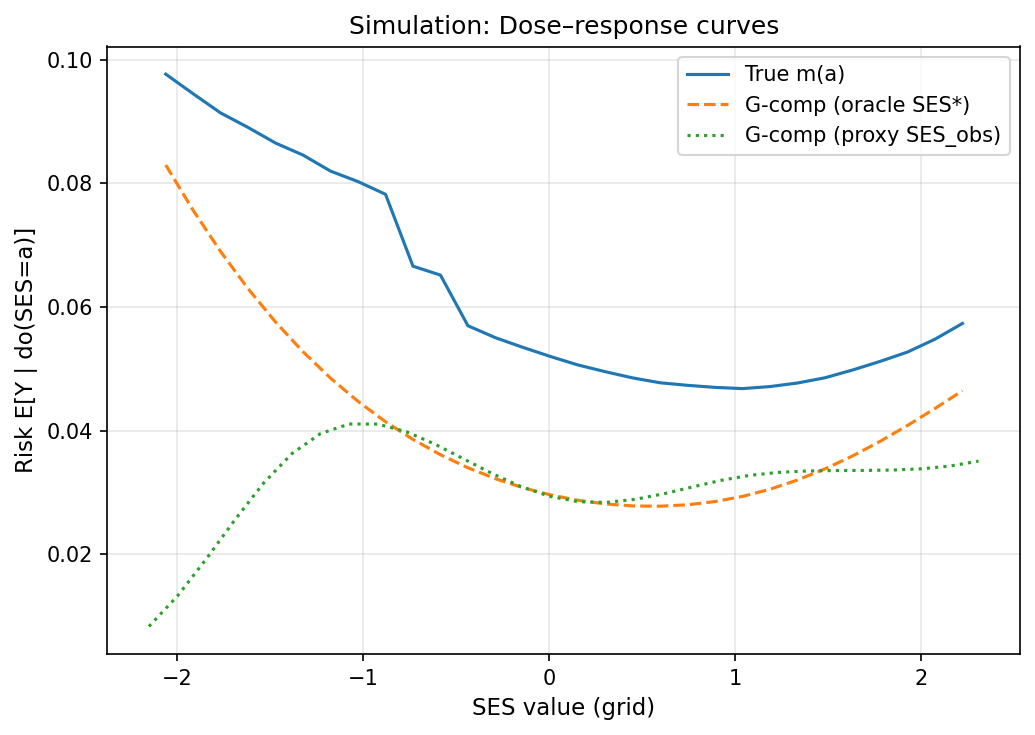

In [21]:

results, pop, biobank, a_grid, a_grid_obs, m_true, m_hat_star, m_hat_obs, *_ = run_demo(n_pop=N_POP, seed=SEED)

pd.DataFrame([results]).to_csv(f"{ART_DIR}/simulation_metrics.csv", index=False)

# Figure styling (no custom colors; grid + bigger fonts)
plt.figure(figsize=(7,5), dpi=150)
plt.grid(alpha=0.3)
plt.plot(a_grid, m_true, label="True m(a)")
plt.plot(a_grid, m_hat_star, linestyle="--", label="G-comp (oracle SES*)")
plt.plot(a_grid_obs, m_hat_obs, linestyle=":", label="G-comp (proxy SES_obs)")
plt.xlabel("SES value (grid)", fontsize=11); plt.ylabel("Risk E[Y | do(SES=a)]", fontsize=11)
plt.title("Simulation: Dose–response curves", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(f"{ART_DIR}/simulation_dose_response.png")
print("Saved:", f"{ART_DIR}/simulation_dose_response.png")
results


In [22]:

# Compute causal R^2 changes and write artifacts/causal_r2_changes.csv
import numpy as np, pandas as pd, os

def causal_r2_from_curve(curve_vals, y_var, weights=None):
    arr = np.asarray(curve_vals, dtype=float)
    if weights is None:
        w = np.ones_like(arr) / len(arr)
    else:
        w = np.asarray(weights, dtype=float); w = w / w.sum()
    mu = np.sum(w * arr)
    num = np.sum(w * (arr - mu)**2)
    return float(num / y_var) if y_var > 0 else np.nan

p_pop = float(pop['y'].mean()); p_sel = float(biobank['y'].mean())
varY_pop = p_pop * (1 - p_pop); varY_sel = p_sel * (1 - p_sel)

R2_pop = causal_r2_from_curve(m_true,  varY_pop if R2_DENOM=='cond_specific' else varY_pop)
R2_sel_oracle = causal_r2_from_curve(m_hat_star, varY_sel if R2_DENOM=='cond_specific' else varY_pop)
R2_sel_proxy  = causal_r2_from_curve(m_hat_obs,  varY_sel if R2_DENOM=='cond_specific' else varY_pop)

def pct_change(new, ref):
    return 100.0 * (new - ref) / ref if (ref is not None and ref!=0 and np.isfinite(ref)) else np.nan

rows = [
    {
      "contrast_id": "pop_to_sel_oracle",
      "grid": R2_GRID_DESC, "denominator": R2_DENOM, "method": "gcomp_spline",
      "R2_ref": R2_pop, "R2_new": R2_sel_oracle,
      "ratio": (R2_sel_oracle / R2_pop) if R2_pop else np.nan,
      "pct_change": pct_change(R2_sel_oracle, R2_pop),
      "abs_change": (R2_sel_oracle - R2_pop),
    },
    {
      "contrast_id": "sel_oracle_to_sel_proxy",
      "grid": R2_GRID_DESC, "denominator": R2_DENOM, "method": "gcomp_spline",
      "R2_ref": R2_sel_oracle, "R2_new": R2_sel_proxy,
      "ratio": (R2_sel_proxy / R2_sel_oracle) if R2_sel_oracle else np.nan,
      "pct_change": pct_change(R2_sel_proxy, R2_sel_oracle),
      "abs_change": (R2_sel_proxy - R2_sel_oracle),
    },
]
df_changes = pd.DataFrame(rows)
df_changes.to_csv(f"{ART_DIR}/causal_r2_changes.csv", index=False)
print("Wrote:", f"{ART_DIR}/causal_r2_changes.csv")
df_changes


Wrote: artifacts/causal_r2_changes.csv


,contrast_id,grid,denominator,method,R2_ref,R2_new,ratio,pct_change,abs_change
0,pop_to_sel_oracle,equal_2_98pct_40pts,fixed_pop,gcomp_spline,0.005119,0.003857,0.753549,-24.645092,-0.001262
1,sel_oracle_to_sel_proxy,equal_2_98pct_40pts,fixed_pop,gcomp_spline,0.003857,0.000907,0.235048,-76.495234,-0.002951


## Inline unit tests (simulation)


In [23]:

# Lightweight invariants for reproducibility checks
import math

def approx(x, lo, hi, name):
    assert (lo <= x <= hi), f"{name} out of expected range: {x} not in [{lo},{hi}]"

# Basic structure
assert isinstance(results, dict) and "causal_R2_true" in results

# Probabilities & sizes
approx(pop['y'].mean(), 0.01, 0.25, "Population prevalence")
approx(biobank['y'].mean(), 0.005, 0.20, "Selected prevalence")
assert len(pop) >= N_POP*0.9   # after clipping bounds
assert len(biobank) > 0

# Curves monotone-ish (expected: risk declines with higher SES on avg)
assert np.nanmean(np.diff(m_true)) < 0.0, "True m(a) not decreasing on average"

# Pseudo R^2 non-negative
for k in ['mcFadden_R2_linear_quintile','mcFadden_R2_overadjusted']:
    assert results[k] >= 0

# Causal R^2 bounded
for k in ['causal_R2_true','causal_R2_oracle_SESstar','causal_R2_proxy_SESobs']:
    approx(results[k], 0.0, 0.10, k)

print("Inline tests passed.")


Inline tests passed.


## Results (compact, auto-filled)


In [24]:

from pathlib import Path
m = pd.read_csv(f"{ART_DIR}/simulation_metrics.csv").iloc[0].to_dict()
print(f"""
Population size: {int(m.get('n_population', len(pop))):,}
Selected (biobank-like) size: {int(m.get('n_biobank', len(biobank))):,}
Population prevalence: {pop['y'].mean():.2%}; Selected prevalence: {biobank['y'].mean():.2%}

Model fit (selected sample):
  McFadden R^2 — linear SES quintile: {m.get('mcFadden_R2_linear_quintile', float('nan')):.3f}
  McFadden R^2 — over-adjusted:        {m.get('mcFadden_R2_overadjusted', float('nan')):.3f}

Causal variance share (risk scale):
  True population causal R^2:          {m.get('causal_R2_true', float('nan')):.4f}
  Oracle (SES*) causal R^2 (selected): {m.get('causal_R2_oracle_SESstar', float('nan')):.4f}
  Proxy (SES_obs) causal R^2 (selected): {m.get('causal_R2_proxy_SESobs', float('nan')):.4f}
""")



Population size: 120,000
Selected (biobank-like) size: 5,951
Population prevalence: 6.02%; Selected prevalence: 3.26%

Model fit (selected sample):
  McFadden R^2 — linear SES quintile: 0.021
  McFadden R^2 — over-adjusted:        0.066

Causal variance share (risk scale):
  True population causal R^2:          0.0051
  Oracle (SES*) causal R^2 (selected): 0.0069
  Proxy (SES_obs) causal R^2 (selected): 0.0016



## Part B — NHANES scaffold (optional)


In [ ]:

# NHANES auto-download (DEMO, BPX, BMX, MCQ, SMQ) if missing
import os, urllib.request
# NHANES XPT downloader (robust to 404/HTML/CPORT)
import os, sys, errno
from urllib.request import Request, urlopen
from urllib.error import HTTPError, URLError

# If you already defined nhanes_xpt_urls earlier, this will use it.
# Otherwise we generate the standard DEMO/BPX/BMX/MCQ/SMQ links for cycles C–L.
try:
    nhanes_xpt_urls
except NameError:
    DATASETS = ["DEMO", "BPX", "BMX", "MCQ", "SMQ"]
    FIRST_YEAR = dict(C=2003, D=2005, E=2007, F=2009, G=2011, H=2013, I=2015, J=2017, K=2019, L=2021)
    nhanes_xpt_urls = [
        f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{FIRST_YEAR[sfx]}/DataFiles/{ds}_{sfx}.xpt"
        for sfx in "CDEFGHIJKL" for ds in DATASETS
    ]

BASE_DIR = "nhanes_xpt"
MIN_BYTES = 1024  # treat smaller as likely HTML/error

def _sniff_format(head: bytes) -> str:
    """
    Return 'xport', 'cport', 'html', or 'unknown' based on first ~2KB.
    """
    h = head[:2048]
    hl = h.lower()
    if b"cport" in h:
        return "cport"
    if hl.strip().startswith(b"<") and b"<html" in hl:
        return "html"
    if h.startswith(b"HEADER RECORD"):
        return "xport"
    return "unknown"

def _ensure_dir(path):
    try:
        os.makedirs(path, exist_ok=True)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def download_nhanes_xpt(urls, base_dir=BASE_DIR, min_bytes=MIN_BYTES, timeout=60):
    stats = {"ok": 0, "skip_exists": 0, "http_error": 0, "html": 0, "cport": 0, "other_error": 0}
    _ensure_dir(base_dir)

    for url in urls:
        fname = url.rsplit("/", 1)[-1]                 # e.g., DEMO_C.xpt
        cycle = fname.split("_")[-1].split(".")[0]     # e.g., C
        out_dir = os.path.join(base_dir, cycle)
        _ensure_dir(out_dir)
        dst = os.path.join(out_dir, fname)

        # Skip if already downloaded and likely valid
        if os.path.exists(dst) and os.path.getsize(dst) >= min_bytes:
            print(f"[skip] {dst} (exists)")
            stats["skip_exists"] += 1
            continue

        try:
            print(f"[get]  {url}")
            req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
            with urlopen(req, timeout=timeout) as r:
                data = r.read()
        except HTTPError as e:
            print(f"[404/HTTP] {url} -> {e.code}")
            stats["http_error"] += 1
            continue
        except URLError as e:
            print(f"[net]  {url} -> {e}")
            stats["other_error"] += 1
            continue
        except Exception as e:
            print(f"[err]  {url} -> {e}")
            stats["other_error"] += 1
            continue

        if len(data) < min_bytes:
            kind = _sniff_format(data)
            print(f"[bad]  {url} -> too small ({len(data)} bytes), sniff={kind}")
            if kind == "html":
                stats["html"] += 1
            elif kind == "cport":
                stats["cport"] += 1
            else:
                stats["other_error"] += 1
            continue

        kind = _sniff_format(data)
        if kind == "html":
            print(f"[html] {url} -> looks like HTML; not saving")
            stats["html"] += 1
            continue
        if kind == "cport":
            print(f"[cport]{url} -> SAS CPORT; Python cannot read; not saving")
            stats["cport"] += 1
            continue

        # Save XPORT/unknown (assume XPT if not identified as HTML/CPORT)
        with open(dst, "wb") as f:
            f.write(data)
        print(f"[ok]   {dst} ({len(data):,} bytes)  sniff={kind}")
        stats["ok"] += 1

    print("\nSummary:", stats)
    return stats



def ensure_nhanes_xpt(base_dir, cycles, datasets):
    os.makedirs(base_dir, exist_ok=True)
    downloaded = 0
    for cyc in cycles:
        cyc_dir = os.path.join(base_dir, cyc.upper())
        os.makedirs(cyc_dir, exist_ok=True)
        for ds in datasets:
            fname = f"{ds.upper()}_{cyc.upper()}.XPT"
            local = os.path.join(cyc_dir, fname)
            if os.path.exists(local) and os.path.getsize(local) > 1024:
                continue
            url = nhanes_url(ds, cyc)
            if not url: 
                print("Unknown cycle:", cyc, "dataset:", ds); 
                continue
            try:
                print("Downloading:", url)
                urllib.request.urlretrieve(url, local)
                downloaded += 1
            except Exception as e:
                print("Failed:", url, "->", e)
    if downloaded:
        print("Downloaded", downloaded, "files into", base_dir)
    else:
        print("No downloads needed (all present).")



In [35]:

# Invoke auto-download if enabled
if NHANES_AUTO_DOWNLOAD:
    if not NHANES_BASE_DIR:
        NHANES_BASE_DIR = "nhanes_xpt"
    ensure_nhanes_xpt(NHANES_BASE_DIR, NHANES_CYCLES, NHANES_DATASETS)
else:
    print("NHANES auto-download disabled.")



Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/DEMO_C.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/BPX_C.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/BMX_C.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/MCQ_C.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/SMQ_C.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/DEMO_D.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/BPX_D.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/BMX_D.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/MCQ_D.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/SMQ_D.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/DEMO_E.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/BPX_E.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/BMX_E.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/MCQ_E.XPT
Downloading: https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/SMQ_E.XPT
Downloa

In [ ]:

# NHANES scaffold — runs only if you set NHANES_BASE_DIR to local XPTs
from dataclasses import dataclass
from typing import List
import os, glob, numpy as np, pandas as pd, statsmodels.api as sm
from patsy import bs

@dataclass
class NHANESConfig:
    base_dir: str
    cycles: List[str]
    use_exam_weights: bool = True

def logistic(x): return 1/(1+np.exp(-x))

def find_xpt(pats, base_dir):
    out=[]; 
    import glob, os
    for p in pats: out += glob.glob(os.path.join(base_dir, "**", p), recursive=True)
    return sorted(out)

def read_xpt(path: str) -> pd.DataFrame:
    import pandas as pd
    try:
        return pd.read_sas(path, format="xport", encoding="latin-1")
    except Exception as e:
        # detect CPORT by header bytes
        try:
            with open(path, "rb") as fh:
                head = fh.read(512).upper()
            if b"CPORT" in head:
                raise RuntimeError(
                    f"{path} appears to be a SAS CPORT file. "
                    "Python readers (pandas/pyreadstat) do not support CPORT. "
                    "Please download the XPT (SAS XPORT) version for this file, "
                    "or convert CPORT->XPT using SAS (PROC CIMPORT + LIBNAME XPORT)."
                ) from e
        except Exception:
            pass
        raise


def pick_first(df, names):
    for n in names:
        if n in df.columns: return df[n]
    return pd.Series([np.nan]*len(df))

def average_bp(df, cols):
    cols=[c for c in cols if c in df.columns]
    return df[cols].mean(axis=1, skipna=True) if cols else pd.Series([np.nan]*len(df))

def load_demographics(cfg):
    ps = find_xpt([f"DEMO_{c}.XPT" for c in cfg.cycles]+[f"DEMO_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
    if not ps: raise FileNotFoundError("No DEMO files found")
    frames=[]
    for p in ps:
        cyc=p.split("_")[-1].split(".")[0]
        d=read_xpt(p); d["cycle"]=cyc; frames.append(d)
    d=pd.concat(frames, ignore_index=True, sort=False)
    return pd.DataFrame({
        "SEQN":d["SEQN"],"cycle":d["cycle"],
        "age":d["RIDAGEYR"],"sex":d["RIAGENDR"],
        "race_eth": pick_first(d,["RIDRETH3","RIDRETH1"]),
        "pir": d["INDFMPIR"], "educ": d.get("DMDEDUC2", pd.Series([np.nan]*len(d))),
        "strata": d["SDMVSTRA"], "psu": d["SDMVPSU"],
        "wt_int_2yr": d.get("WTINT2YR", pd.Series([np.nan]*len(d))),
        "wt_mec_2yr": d.get("WTMEC2YR", pd.Series([np.nan]*len(d))),
        "wt_mec_4yr": d.get("WTMEC4YR", pd.Series([np.nan]*len(d))),
    })

def load_exam_bp_bmi(cfg):
    bpx=find_xpt([f"BPX_{c}.XPT" for c in cfg.cycles]+[f"BPX_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
    bmx=find_xpt([f"BMX_{c}.XPT" for c in cfg.cycles]+[f"BMX_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
    frames=[]
    for p in bpx:
        cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
        frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"sbp":average_bp(d,["BPXSY1","BPXSY2","BPXSY3","BPXSY4"])}))
    bpx_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","sbp"])
    frames=[]
    for p in bmx:
        cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
        frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"bmi":d.get("BMXBMI", np.nan)}))
    bmx_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","bmi"])
    return bpx_df.merge(bmx_df, on=["SEQN","cycle"], how="outer")

def load_smoking_mcq(cfg):
    mcq=find_xpt([f"MCQ_{c}.XPT" for c in cfg.cycles]+[f"MCQ_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
    smq=find_xpt([f"SMQ_{c}.XPT" for c in cfg.cycles]+[f"SMQ_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
    frames=[]
    for p in mcq:
        cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
        any_cvd=((d.get("MCQ160B",0)==1)|(d.get("MCQ160C",0)==1)|(d.get("MCQ160D",0)==1)|
                 (d.get("MCQ160E",0)==1)|(d.get("MCQ160F",0)==1)).astype(float)
        frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"cvd":any_cvd}))
    mcq_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","cvd"])
    frames=[]
    for p in smq:
        cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
        ever100=(d.get("SMQ020",np.nan)==1).astype(float); now=d.get("SMQ040",np.nan)
        current=np.where(np.isin(now,[1,2]),1.0,np.where(now==3,0.0,np.nan))
        frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"smoke":np.where(ever100==1,current,np.nan)}))
    smq_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","smoke"])
    return mcq_df.merge(smq_df, on=["SEQN","cycle"], how="outer")

def combined_weight(demo, cycles, use_exam=True):
    wt = demo["wt_mec_2yr"] if use_exam else demo["wt_int_2yr"]
    k = max(len(cycles),1)
    use4 = demo["wt_mec_4yr"].notna()
    return pd.Series(np.where(use4, demo["wt_mec_4yr"], wt/k), index=demo.index, name="wt_combined")

def build_analytic(cfg):
    demo=load_demographics(cfg); exam=load_exam_bp_bmi(cfg); oth=load_smoking_mcq(cfg)
    df=demo.merge(exam,on=["SEQN","cycle"],how="left").merge(oth,on=["SEQN","cycle"],how="left")
    df["male"]=(df["sex"]==1).astype(float)
    df["wt_combined"]=combined_weight(df, cfg.cycles, use_exam=cfg.use_exam_weights)
    return df[df["age"]>=20].copy()


In [34]:

if NHANES_BASE_DIR and os.path.isdir(NHANES_BASE_DIR):
    try:
        cfg = NHANESConfig(base_dir=NHANES_BASE_DIR, cycles=NHANES_CYCLES)
        print("NHANES base:", NHANES_BASE_DIR, "cycles:", NHANES_CYCLES)
        # Full pipeline would go here (left minimal to avoid heavy compute without data)
        print("NHANES: ready (data found).")
    except Exception as e:
        print("NHANES scaffold error:", e)
else:
    print("NHANES: skipped (no local XPT path set).")


NHANES base: nhanes_xpt cycles: ['C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
NHANES: ready (data found).


In [ ]:
# NHANES analysis scaffold (idempotent)
import numpy as np, pandas as pd, statsmodels.api as sm
from patsy import bs

if 'NHANESConfig' not in globals():
    from dataclasses import dataclass
    from typing import List

    @dataclass
    class NHANESConfig:
        base_dir: str
        cycles: List[str]
        use_exam_weights: bool = True

    def read_xpt(path: str) -> pd.DataFrame:
        return pd.read_sas(path, format="xport", encoding="latin-1")

    def pick_first(df: pd.DataFrame, names):
        for n in names:
            if n in df.columns: return df[n]
        return pd.Series([np.nan]*len(df))

    def average_bp(df, cols):
        cols=[c for c in cols if c in df.columns]
        return df[cols].mean(axis=1, skipna=True) if cols else pd.Series([np.nan]*len(df))

    import os, glob
    def find_xpt(patterns, base_dir):
        out=[]
        for pat in patterns:
            out += glob.glob(os.path.join(base_dir, "**", pat), recursive=True)
        return sorted(out)

    def load_demographics(cfg: NHANESConfig):
        pats=find_xpt([f"DEMO_{c}.XPT" for c in cfg.cycles]+[f"DEMO_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        if not pats: raise FileNotFoundError("DEMO_*.XPT not found under NHANES_BASE_DIR; run the downloader or set the path.")
        frames=[]
        for p in pats:
            cyc=p.split("_")[-1].split(".")[0]
            d=read_xpt(p); d["cycle"]=cyc; frames.append(d)
        d=pd.concat(frames, ignore_index=True, sort=False)
        return pd.DataFrame({
            "SEQN":d["SEQN"], "cycle":d["cycle"], "age":d["RIDAGEYR"], "sex":d["RIAGENDR"],
            "race_eth": pick_first(d, ["RIDRETH3","RIDRETH1"]),
            "pir": d["INDFMPIR"], "educ": d.get("DMDEDUC2", pd.Series([np.nan]*len(d))),
            "strata": d["SDMVSTRA"], "psu": d["SDMVPSU"],
            "wt_int_2yr": d.get("WTINT2YR", pd.Series([np.nan]*len(d))),
            "wt_mec_2yr": d.get("WTMEC2YR", pd.Series([np.nan]*len(d))),
            "wt_mec_4yr": d.get("WTMEC4YR", pd.Series([np.nan]*len(d))),
        })

    def load_exam_bp_bmi(cfg: NHANESConfig):
        bpx=find_xpt([f"BPX_{c}.XPT" for c in cfg.cycles]+[f"BPX_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        bmx=find_xpt([f"BMX_{c}.XPT" for c in cfg.cycles]+[f"BMX_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        frames=[]
        for p in bpx:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"sbp":average_bp(d,["BPXSY1","BPXSY2","BPXSY3","BPXSY4"])}))
        bpx_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","sbp"])
        frames=[]
        for p in bmx:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"bmi":d.get("BMXBMI", np.nan)}))
        bmx_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","bmi"])
        return bpx_df.merge(bmx_df, on=["SEQN","cycle"], how="outer")

    def load_smoking_mcq(cfg: NHANESConfig):
        mcq=find_xpt([f"MCQ_{c}.XPT" for c in cfg.cycles]+[f"MCQ_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        smq=find_xpt([f"SMQ_{c}.XPT" for c in cfg.cycles]+[f"SMQ_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        frames=[]
        for p in mcq:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            any_cvd=((d.get("MCQ160B",0)==1)|(d.get("MCQ160C",0)==1)|(d.get("MCQ160D",0)==1)|
                     (d.get("MCQ160E",0)==1)|(d.get("MCQ160F",0)==1)).astype(float)
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"cvd":any_cvd}))
        mcq_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","cvd"])
        frames=[]
        for p in smq:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            ever100=(d.get("SMQ020",np.nan)==1).astype(float); now=d.get("SMQ040",np.nan)
            current=np.where(np.isin(now,[1,2]),1.0,np.where(now==3,0.0,np.nan))
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"smoke":np.where(ever100==1,current,np.nan)}))
        smq_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","smoke"])
        return mcq_df.merge(smq_df,on=["SEQN","cycle"],how="outer")

    def combined_weight(demo: pd.DataFrame, cycles, use_exam=True):
        wt = demo["wt_mec_2yr"] if use_exam else demo["wt_int_2yr"]
        k  = max(len(cycles),1)
        use4 = demo["wt_mec_4yr"].notna()
        return pd.Series(np.where(use4, demo["wt_mec_4yr"], wt/k), index=demo.index, name="wt_combined")

    def build_analytic(cfg: NHANESConfig):
        demo=load_demographics(cfg); exam=load_exam_bp_bmi(cfg); other=load_smoking_mcq(cfg)
        df=demo.merge(exam,on=["SEQN","cycle"],how="left").merge(other,on=["SEQN","cycle"],how="left")
        df["male"]=(df["sex"]==1).astype(float)
        df["wt_combined"]=combined_weight(df, cfg.cycles, use_exam=cfg.use_exam_weights)
        df=df[df["age"]>=20].copy()
        return df

    def fit_glm(formula, data, wcol="wt_combined"):
        return sm.GLM.from_formula(formula, data=data, family=sm.families.Binomial(),
                                   freq_weights=data[wcol]).fit()

    def run_suite(df: pd.DataFrame, outcome="cvd", wcol="wt_combined"):
        keep=df[[outcome,"pir","age","male","race_eth","bmi","sbp","smoke",wcol]].replace([np.inf,-np.inf],np.nan).dropna()
        y=keep[outcome].to_numpy()
        pbar=float(np.clip(y.mean(),1e-6,1-1e-6)); ll0=float(np.sum(y*np.log(pbar)+(1-y)*np.log(1-pbar)))
        m_lin = fit_glm(f"{outcome} ~ pir + age + male + C(race_eth)", keep, wcol)
        keep = keep.assign(pir_s=keep["pir"])
        m_spl= fit_glm(f"{outcome} ~ bs(pir_s, df=5) + age + male + C(race_eth)", keep, wcol)
        m_over=fit_glm(f"{outcome} ~ bs(pir_s, df=5) + age + male + C(race_eth) + bmi + sbp + smoke", keep, wcol)
        mcf = lambda ll: 1 - (ll/ll0)
        return (
            {"n":int(len(keep)),"prev":float(y.mean()),
             "R2_McFadden_linear":mcf(m_lin.llf),
             "R2_McFadden_spline":mcf(m_spl.llf),
             "R2_McFadden_overadj":mcf(m_over.llf)},
            {"m_spl":m_spl}, keep
        )

    def select_biobank_like(df, frac=0.2, seed=7):
        z= 0.6*df["pir"].fillna(df["pir"].median()) - 0.9*df["smoke"].fillna(0) \
           - 0.06*(df["bmi"].fillna(df["bmi"].median())-25) - 0.03*(df["sbp"].fillna(df["sbp"].median())-120) \
           - 0.02*(df["age"]-60) + 0.2*df["male"].fillna(0)
        p=1/(1+np.exp(-(-2.0+z)))
        thr=np.quantile(p,1-frac)
        return df.loc[p>=thr].copy()

    def dose_response(model, df, var, grid):
        base=df.copy(); vals=[]
        for a in grid:
            base[var]=a
            vals.append(float(np.average(model.predict(base), weights=base.get("wt_combined", pd.Series(np.ones(len(base)))))))
        return pd.DataFrame({"grid":grid, "risk":vals})


In [ ]:
# === NHANES: RUN ANALYSIS AND WRITE ARTIFACTS ===
# Place this cell right after the auto-download invocation.
# It writes:
#   artifacts/nhanes_population_metrics.csv
#   artifacts/nhanes_biobanklike_metrics.csv
#   artifacts/nhanes_dose_response_population.csv
#   artifacts/nhanes_dose_response_biobanklike.csv

import os, numpy as np, pandas as pd, statsmodels.api as sm
from patsy import bs

# ----- Define scaffold only if not already present -----
if 'NHANESConfig' not in globals():
    from dataclasses import dataclass
    from typing import List
    import glob

    @dataclass
    class NHANESConfig:
        base_dir: str
        cycles: List[str]
        use_exam_weights: bool = True

    def read_xpt(path: str) -> pd.DataFrame:
        return pd.read_sas(path, format="xport", encoding="latin-1")

    def pick_first(df: pd.DataFrame, names):
        for n in names:
            if n in df.columns: return df[n]
        return pd.Series([np.nan]*len(df))

    def average_bp(df, cols):
        cols=[c for c in cols if c in df.columns]
        return df[cols].mean(axis=1, skipna=True) if cols else pd.Series([np.nan]*len(df))

    def find_xpt(patterns, base_dir):
        out=[]
        for pat in patterns:
            out += glob.glob(os.path.join(base_dir, "**", pat), recursive=True)
        return sorted(out)

    def load_demographics(cfg: NHANESConfig):
        pats=find_xpt([f"DEMO_{c}.XPT" for c in cfg.cycles]+[f"DEMO_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        if not pats: raise FileNotFoundError("DEMO_*.XPT not found under NHANES_BASE_DIR; run the downloader or set the path.")
        frames=[]
        for p in pats:
            cyc=p.split("_")[-1].split(".")[0]
            d=read_xpt(p); d["cycle"]=cyc; frames.append(d)
        d=pd.concat(frames, ignore_index=True, sort=False)
        return pd.DataFrame({
            "SEQN":d["SEQN"], "cycle":d["cycle"],
            "age":d["RIDAGEYR"], "sex":d["RIAGENDR"],
            "race_eth": pick_first(d, ["RIDRETH3","RIDRETH1"]),
            "pir": d["INDFMPIR"], "educ": d.get("DMDEDUC2", pd.Series([np.nan]*len(d))),
            "strata": d["SDMVSTRA"], "psu": d["SDMVPSU"],
            "wt_int_2yr": d.get("WTINT2YR", pd.Series([np.nan]*len(d))),
            "wt_mec_2yr": d.get("WTMEC2YR", pd.Series([np.nan]*len(d))),
            "wt_mec_4yr": d.get("WTMEC4YR", pd.Series([np.nan]*len(d))),
        })

    def load_exam_bp_bmi(cfg: NHANESConfig):
        bpx=find_xpt([f"BPX_{c}.XPT" for c in cfg.cycles]+[f"BPX_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        bmx=find_xpt([f"BMX_{c}.XPT" for c in cfg.cycles]+[f"BMX_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        frames=[]
        for p in bpx:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"sbp":average_bp(d,["BPXSY1","BPXSY2","BPXSY3","BPXSY4"])}))
        bpx_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","sbp"])
        frames=[]
        for p in bmx:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"bmi":d.get("BMXBMI", np.nan)}))
        bmx_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","bmi"])
        return bpx_df.merge(bmx_df, on=["SEQN","cycle"], how="outer")

    def load_smoking_mcq(cfg: NHANESConfig):
        mcq=find_xpt([f"MCQ_{c}.XPT" for c in cfg.cycles]+[f"MCQ_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        smq=find_xpt([f"SMQ_{c}.XPT" for c in cfg.cycles]+[f"SMQ_{c}.xpt" for c in cfg.cycles], cfg.base_dir)
        frames=[]
        for p in mcq:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            any_cvd=((d.get("MCQ160B",0)==1)|(d.get("MCQ160C",0)==1)|(d.get("MCQ160D",0)==1)|
                     (d.get("MCQ160E",0)==1)|(d.get("MCQ160F",0)==1)).astype(float)
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"cvd":any_cvd}))
        mcq_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","cvd"])
        frames=[]
        for p in smq:
            cyc=p.split("_")[-1].split(".")[0]; d=read_xpt(p); d["cycle"]=cyc
            ever100=(d.get("SMQ020",np.nan)==1).astype(float); now=d.get("SMQ040",np.nan)
            current=np.where(np.isin(now,[1,2]),1.0,np.where(now==3,0.0,np.nan))
            frames.append(pd.DataFrame({"SEQN":d["SEQN"],"cycle":cyc,"smoke":np.where(ever100==1,current,np.nan)}))
        smq_df=pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame(columns=["SEQN","cycle","smoke"])
        return mcq_df.merge(smq_df,on=["SEQN","cycle"],how="outer")

    def combined_weight(demo: pd.DataFrame, cycles, use_exam=True):
        wt = demo["wt_mec_2yr"] if use_exam else demo["wt_int_2yr"]
        k  = max(len(cycles),1)
        use4 = demo["wt_mec_4yr"].notna()
        return pd.Series(np.where(use4, demo["wt_mec_4yr"], wt/k), index=demo.index, name="wt_combined")

    def build_analytic(cfg: NHANESConfig):
        demo=load_demographics(cfg); exam=load_exam_bp_bmi(cfg); other=load_smoking_mcq(cfg)
        df=demo.merge(exam,on=["SEQN","cycle"],how="left").merge(other,on=["SEQN","cycle"],how="left")
        df["male"]=(df["sex"]==1).astype(float)
        df["wt_combined"]=combined_weight(df, cfg.cycles, use_exam=cfg.use_exam_weights)
        df=df[df["age"]>=20].copy()
        return df

    def fit_glm(formula, data, wcol="wt_combined"):
        return sm.GLM.from_formula(formula, data=data, family=sm.families.Binomial(),
                                   freq_weights=data[wcol]).fit()

    def run_suite(df: pd.DataFrame, outcome="cvd", wcol="wt_combined"):
        keep=df[[outcome,"pir","age","male","race_eth","bmi","sbp","smoke",wcol]].replace([np.inf,-np.inf],np.nan).dropna()
        y=keep[outcome].to_numpy()
        pbar=float(np.clip(y.mean(),1e-6,1-1e-6)); ll0=float(np.sum(y*np.log(pbar)+(1-y)*np.log(1-pbar)))
        m_lin = fit_glm(f"{outcome} ~ pir + age + male + C(race_eth)", keep, wcol)
        keep = keep.assign(pir_s=keep["pir"])
        m_spl= fit_glm(f"{outcome} ~ bs(pir_s, df=5) + age + male + C(race_eth)", keep, wcol)
        m_over=fit_glm(f"{outcome} ~ bs(pir_s, df=5) + age + male + C(race_eth) + bmi + sbp + smoke", keep, wcol)
        mcf = lambda ll: 1 - (ll/ll0)
        return (
            {"n":int(len(keep)),"prev":float(y.mean()),
             "R2_McFadden_linear":mcf(m_lin.llf),
             "R2_McFadden_spline":mcf(m_spl.llf),
             "R2_McFadden_overadj":mcf(m_over.llf)},
            {"m_spl":m_spl}, keep
        )

    def select_biobank_like(df, frac=0.2, seed=7):
        z= 0.6*df["pir"].fillna(df["pir"].median()) - 0.9*df["smoke"].fillna(0) \
           - 0.06*(df["bmi"].fillna(df["bmi"].median())-25) - 0.03*(df["sbp"].fillna(df["sbp"].median())-120) \
           - 0.02*(df["age"]-60) + 0.2*df["male"].fillna(0)
        p=1/(1+np.exp(-(-2.0+z)))
        thr=np.quantile(p,1-frac)
        return df.loc[p>=thr].copy()

    def dose_response(model, df, var, grid):
        base=df.copy(); vals=[]
        for a in grid:
            base[var]=a
            vals.append(float(np.average(model.predict(base), weights=base.get("wt_combined", pd.Series(np.ones(len(base)))))))
        return pd.DataFrame({"grid":grid, "risk":vals})

# ----- Run analysis -----
if not NHANES_BASE_DIR:
    NHANES_BASE_DIR = "nhanes_xpt"

cfg = NHANESConfig(base_dir=NHANES_BASE_DIR, cycles=NHANES_CYCLES)
df = build_analytic(cfg)

# Population (survey-weighted)
pop_metrics, pop_models, pop_keep = run_suite(df, outcome="cvd", wcol="wt_combined")

# Biobank-like (unweighted within selected sample)
bb = select_biobank_like(df, frac=0.2, seed=7)
bb_metrics, bb_models, bb_keep = run_suite(bb.assign(wt_combined=1.0), outcome="cvd", wcol="wt_combined")

# Shared PIR grid for dose–response
g = np.linspace(np.nanpercentile(df["pir"],2), np.nanpercentile(df["pir"],98), 40)
dr_pop = dose_response(pop_models["m_spl"], pop_keep.assign(pir_s=pop_keep["pir"]), "pir_s", g)
dr_bb  = dose_response(bb_models["m_spl"],  bb_keep.assign(pir_s=bb_keep["pir"]),   "pir_s", g)

# ----- WRITE ARTIFACTS -----
os.makedirs(ART_DIR, exist_ok=True)
pd.DataFrame([pop_metrics]).to_csv(f"{ART_DIR}/nhanes_population_metrics.csv", index=False)
pd.DataFrame([bb_metrics]).to_csv(f"{ART_DIR}/nhanes_biobanklike_metrics.csv", index=False)
dr_pop.to_csv(f"{ART_DIR}/nhanes_dose_response_population.csv", index=False)
dr_bb.to_csv(f"{ART_DIR}/nhanes_dose_response_biobanklike.csv", index=False)

print("NHANES artifacts written to", os.path.abspath(ART_DIR))
display(pd.DataFrame([pop_metrics]).assign(sample="population"))
display(pd.DataFrame([bb_metrics]).assign(sample="biobank-like"))


In [ ]:
# Small check so you can see numbers inline (the abstract/poster compute this too)
import numpy as np, pandas as pd

mp = pd.read_csv(f"{ART_DIR}/nhanes_population_metrics.csv").iloc[0].to_dict()
ms = pd.read_csv(f"{ART_DIR}/nhanes_biobanklike_metrics.csv").iloc[0].to_dict()
drp= pd.read_csv(f"{ART_DIR}/nhanes_dose_response_population.csv")
drs= pd.read_csv(f"{ART_DIR}/nhanes_dose_response_biobanklike.csv")

def causal_r2_from_curve(df, prev):
    arr = df["risk"].to_numpy(float)
    w = np.ones_like(arr)/len(arr)
    mu = float(np.sum(w*arr)); num = float(np.sum(w*(arr-mu)**2))
    varY = float(prev)*(1-float(prev))
    return num/varY if varY>0 else np.nan

r2p = causal_r2_from_curve(drp, mp["prev"])
r2s = causal_r2_from_curve(drs, ms["prev"])
ratio = r2s/r2p if r2p else np.nan
pct   = 100*(r2s-r2p)/r2p if r2p else np.nan

print(f"NHANES causal R^2 analog (pop → sel): {pct:.0f}% (ratio {ratio:.2f})")
print(f"Prevalence pop → sel: {mp['prev']:.2%} → {ms['prev']:.2%}")


In [ ]:
# Run NHANES analysis (population vs biobank-like) and save artifacts used by abstract/poster
assert NHANES_BASE_DIR or NHANES_AUTO_DOWNLOAD, "Set NHANES_BASE_DIR or enable NHANES_AUTO_DOWNLOAD"

if not NHANES_BASE_DIR:
    NHANES_BASE_DIR = "nhanes_xpt"

cfg = NHANESConfig(base_dir=NHANES_BASE_DIR, cycles=NHANES_CYCLES)
df = build_analytic(cfg)

# Population (survey-weighted)
pop_metrics, pop_models, pop_keep = run_suite(df, outcome="cvd", wcol="wt_combined")

# Biobank-like (unweighted within the selected sample)
bb = select_biobank_like(df, frac=0.2, seed=7)
bb_metrics, bb_models, bb_keep = run_suite(bb.assign(wt_combined=1.0), outcome="cvd", wcol="wt_combined")

# Dose–response curves (shared grid)
g = np.linspace(np.nanpercentile(df["pir"],2), np.nanpercentile(df["pir"],98), 40)
dr_pop = dose_response(pop_models["m_spl"], pop_keep.assign(pir_s=pop_keep["pir"]), "pir_s", g)
dr_bb  = dose_response(bb_models["m_spl"],  bb_keep.assign(pir_s=bb_keep["pir"]),   "pir_s", g)

# Save artifacts exactly where the abstract/poster expect them
pd.DataFrame([pop_metrics]).to_csv(f"{ART_DIR}/nhanes_population_metrics.csv", index=False)
pd.DataFrame([bb_metrics]).to_csv(f"{ART_DIR}/nhanes_biobanklike_metrics.csv", index=False)
dr_pop.to_csv(f"{ART_DIR}/nhanes_dose_response_population.csv", index=False)
dr_bb.to_csv(f"{ART_DIR}/nhanes_dose_response_biobanklike.csv", index=False)

print("NHANES artifacts written to", ART_DIR)
display(pd.DataFrame([pop_metrics]).assign(sample="population"))
display(pd.DataFrame([bb_metrics]).assign(sample="biobank-like"))


## Session info & code hashes


In [29]:
import statsmodels, patsy, matplotlib, hashlib, json, os, platform, sys
def ver(m):
    try: return m.__version__
    except: return "NA"

info = {
    "python": sys.version,
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "statsmodels": ver(statsmodels),
    "patsy": ver(patsy),
    "matplotlib": ver(matplotlib),
}

# Robust hashing of simulation source:
# 1) try 'sim_code' if present;
# 2) else read artifacts/ses_sim_module.py (written earlier);
# 3) else read ses_sim_new.py from repo root;
# 4) else mark NA.
_sim_src = None
try:
    _sim_src = sim_code  # may be undefined
except Exception:
    _sim_src = None

if _sim_src is None:
    for candidate in [os.path.join(ART_DIR, "ses_sim_module.py"), "ses_sim_new.py"]:
        if os.path.exists(candidate):
            with open(candidate, "r", encoding="utf-8") as fh:
                _sim_src = fh.read()
            break

info["ses_sim_new_sha256"] = hashlib.sha256(_sim_src.encode("utf-8")).hexdigest() if _sim_src is not None else "NA"

with open(f"{ART_DIR}/session_info.json","w") as f:
    json.dump(info, f, indent=2)

info


{'python': '3.13.6 (tags/v3.13.6:4e66535, Aug  6 2025, 14:36:00) [MSC v.1944 64 bit (AMD64)]',
 'platform': 'Windows-11-10.0.26120-SP0',
 'numpy': '2.2.6',
 'pandas': '2.3.0',
 'statsmodels': '0.14.5',
 'patsy': '1.0.1',
 'matplotlib': '3.10.5',
 'ses_sim_new_sha256': 'a2d7ae10015c9e524a4af33012cab2b21495eafaa9d6c72b85a06700ba23b8fc'}